## Load Segmentation Data and Extract a Point Cloud ## 


In [31]:
import numpy as np
import tifffile as tiff
from pathlib import Path
import tifffile as tiff
import os

# windows is the antichrist
cwd = os.getcwd()
print(cwd)
nuc = tiff.imread(r"c:\Users\g7712_razer2\cheng_lab_data\prostate_reconstruction_b8\image_processing\nucmask_1.tiff")
print(nuc.shape)


c:\Users\g7712_razer2\cheng_lab_data\prostate_reconstruction_b8\image_processing
(256, 256, 256)


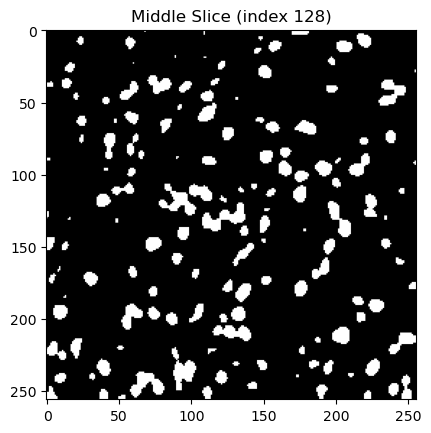

Extracted 147 centroids from the slice.
Centroids: [(0.5, 68.0), (1.5, 109.0), (1.4680851063829787, 175.38297872340425), (7.293333333333333, 219.65333333333334), (7.523809523809524, 23.38095238095238), (8.951219512195122, 57.75609756097561), (5.714285714285714, 148.0), (11.211538461538462, 157.8846153846154), (11.56, 205.86666666666667), (14.375, 145.8125), (18.5, 89.0), (19.0, 109.5), (21.80952380952381, 197.23809523809524), (24.5, 121.0), (26.142857142857142, 16.085714285714285), (23.0, 60.0), (29.17910447761194, 151.0), (28.5, 255.0), (37.74418604651163, 77.90697674418605), (37.05128205128205, 13.717948717948717), (36.0, 116.38095238095238), (43.51912568306011, 238.46448087431693), (37.875, 2.0625), (42.67045454545455, 57.30681818181818), (39.38297872340426, 95.8936170212766), (40.857142857142854, 197.22857142857143), (45.94444444444444, 111.25925925925925), (46.0, 20.285714285714285), (49.0, 41.0), (47.5, 131.5), (57.74766355140187, 111.24299065420561), (53.5, 92.0), (60.6779661016

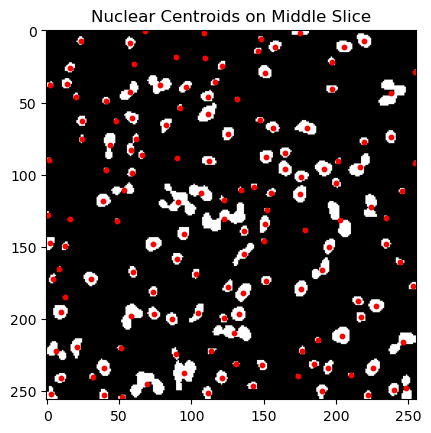

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, center_of_mass

# Assume `segmask` is your 3D NumPy array (segmentation mask)
# Get the shape of the ndarray (should be something like (Z, Y, X))
shape = nuc.shape

# Dynamically calculate the middle slice index along the Z-axis
middle_index = shape[0] // 2  # Integer division to get the middle index

# Extract the middle slice
middle_slice = nuc[middle_index, :, :]

# Visualize to verify (optional)
import matplotlib.pyplot as plt
plt.imshow(middle_slice, cmap='gray')
plt.title(f"Middle Slice (index {middle_index})")
plt.show()

###
# Label connected components (nuclei) in the middle slice
labeled_slice, num_features = label(middle_slice)

# Calculate centroids of the connected components
centroids = center_of_mass(middle_slice, labeled_slice, range(1, num_features + 1))

# Print or store the centroids for further use
print(f"Extracted {len(centroids)} centroids from the slice.")
print("Centroids:", centroids)

# Convert centroids to a NumPy array for further processing if needed
centroid_points = np.array(centroids)

# Plot the middle slice
plt.imshow(middle_slice, cmap='gray')

# Plot the centroids as red dots
if len(centroid_points) > 0:
    plt.scatter([c[1] for c in centroid_points], [c[0] for c in centroid_points], color='red',  s=10)

plt.title("Nuclear Centroids on Middle Slice")
plt.show()



## Given this dummy point cloud lets assess the feasibility of a rips filtration ##

We need some way to estimate a good interval bound

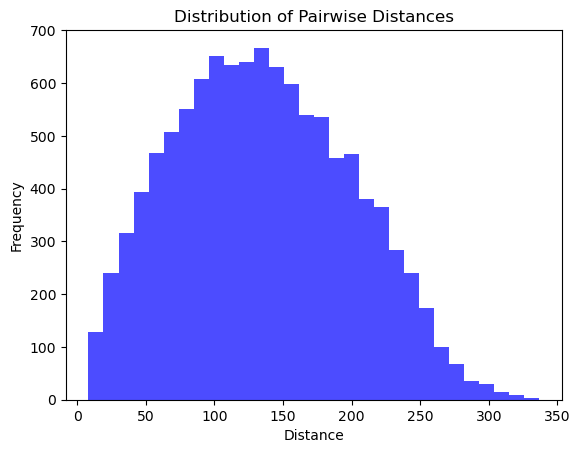

Min distance: 8.099091519838023
Max distance: 336.8741175535822
Mean distance: 135.59859718947027
Median distance: 132.2271805759234
90th percentile: 223.67270316107417


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

# Assuming point_cloud is your sampled point cloud (N x 2 or N x 3)
point_cloud = centroid_points  # NumPy array

# Step 1: Compute pairwise distances
pairwise_distances = distance.pdist(point_cloud, metric='euclidean')

# Step 2: Visualize the distribution of pairwise distances
plt.hist(pairwise_distances, bins=30, color='blue', alpha=0.7)
plt.title("Distribution of Pairwise Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

# Step 3: Compute statistics for guidance (e.g., percentiles)
min_distance = np.min(pairwise_distances)
max_distance = np.max(pairwise_distances)
mean_distance = np.mean(pairwise_distances)
median_distance = np.median(pairwise_distances)
percentile_90 = np.percentile(pairwise_distances, 90)

print(f"Min distance: {min_distance}")
print(f"Max distance: {max_distance}")
print(f"Mean distance: {mean_distance}")
print(f"Median distance: {median_distance}")
print(f"90th percentile: {percentile_90}")


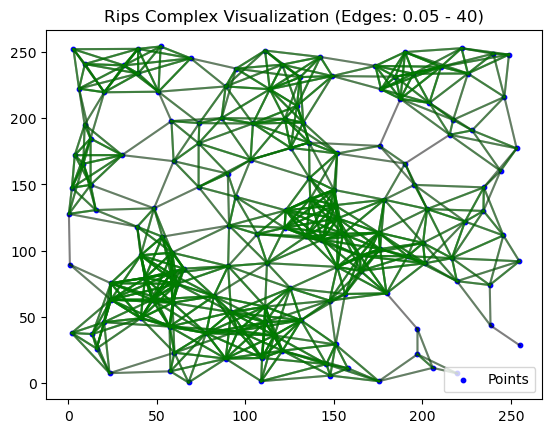

In [47]:
import gudhi as gd
import matplotlib.pyplot as plt
import numpy as np

# Load your point cloud (centroids of nuclei in 2D slice)
point_cloud = centroid_points  # Assuming this is a NumPy array of shape (N, 2) for 2D centroids

# Define the edge length interval (min_edge_length, max_edge_length)
min_edge_length = 0.05

## this parameter is the key determinant of time cost
max_edge_length = 40

# Create a Rips complex with a higher max_edge_length
rips_complex = gd.RipsComplex(points=point_cloud, max_edge_length=max_edge_length)

# Create a simplex tree for the Rips complex, specifying max dimension
simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)

# Convert the filtration generator to a list for processing
filtration = list(simplex_tree.get_filtration())

# Filter simplices based on the specified edge length interval
filtered_simplices = [simplex for simplex, filtration_value in filtration 
                      if min_edge_length <= filtration_value <= max_edge_length]

# Plot the original point cloud
plt.scatter(point_cloud[:, 1], point_cloud[:, 0], color='blue', s=10, label='Points')

# Plot the edges (1-simplices) within the specified edge length range
for simplex, filtration_value in filtration:
    if len(simplex) == 2 and min_edge_length <= filtration_value <= max_edge_length:  # 1-simplex (edge)
        i, j = simplex
        plt.plot([point_cloud[i][1], point_cloud[j][1]], [point_cloud[i][0], point_cloud[j][0]], 'k-', alpha=0.5)

# Optionally, plot the triangles (2-simplices) in the range
for simplex, filtration_value in filtration:
    if len(simplex) == 3 and min_edge_length <= filtration_value <= max_edge_length:  # 2-simplex (triangle)
        i, j, k = simplex
        plt.plot([point_cloud[i][1], point_cloud[j][1]], [point_cloud[i][0], point_cloud[j][0]], 'g-', alpha=0.2)
        plt.plot([point_cloud[j][1], point_cloud[k][1]], [point_cloud[j][0], point_cloud[k][0]], 'g-', alpha=0.2)
        plt.plot([point_cloud[k][1], point_cloud[i][1]], [point_cloud[k][0], point_cloud[i][0]], 'g-', alpha=0.2)

plt.title(f"Rips Complex Visualization (Edges: {min_edge_length} - {max_edge_length})")
plt.legend()
plt.show()


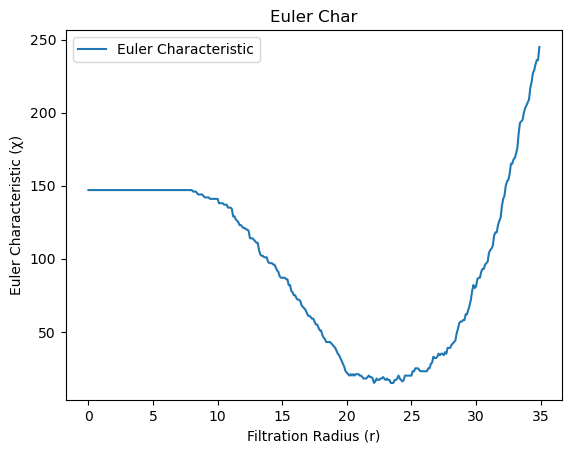

In [58]:
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt

# Define filtration range and step size
max_edge_length = 35
step = .1
filtration_values = np.arange(0, max_edge_length, step)

# Create a Rips complex and simplex tree
rips_complex = gd.RipsComplex(points=point_cloud, max_edge_length=max_edge_length)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

# Function to calculate Euler characteristic at a given filtration value r
def compute_euler_characteristic(simplex_tree, filtration_value):
    V, E, F = 0, 0, 0  # Number of vertices, edges, and faces

    # Parse simplices from the simplex tree based on their dimension and filtration value
    for simplex, filtration in simplex_tree.get_filtration():
        if filtration <= filtration_value:
            if len(simplex) == 1:  # 0-simplex (vertex)
                V += 1
            elif len(simplex) == 2:  # 1-simplex (edge)
                E += 1
            elif len(simplex) == 3:  # 2-simplex (triangle)
                F += 1

    # Calculate Euler characteristic: V - E + F
    return V - E + F

# Compute Euler characteristic for each filtration value
euler_characteristics = [compute_euler_characteristic(simplex_tree, f) for f in filtration_values]

# Plot the Euler characteristic curve as a function of radius r
plt.plot(filtration_values, euler_characteristics, label='Euler Characteristic')
plt.xlabel('Filtration Radius (r)')
plt.ylabel('Euler Characteristic (χ)')
plt.title('Euler Char')
plt.legend()
plt.show()


Persistence intervals for homology groups:
Dimension 1: Birth = 24.200210299553053, Death = inf
Dimension 1: Birth = 38.28180917329073, Death = inf
Dimension 1: Birth = 37.433263755542505, Death = inf
Dimension 1: Birth = 34.404768643643244, Death = inf
Dimension 1: Birth = 33.26886755520836, Death = inf
Dimension 1: Birth = 32.10231721649922, Death = inf
Dimension 1: Birth = 29.880344191596325, Death = inf
Dimension 1: Birth = 29.448192269225725, Death = inf
Dimension 1: Birth = 28.58356619381005, Death = inf
Dimension 1: Birth = 26.825645759381572, Death = inf
Dimension 1: Birth = 24.66573591368359, Death = inf
Dimension 1: Birth = 22.96625554525379, Death = 39.72530232328551
Dimension 1: Birth = 25.042697103161476, Death = 38.14093913478625
Dimension 1: Birth = 23.979558052424032, Death = 37.049925307423536
Dimension 1: Birth = 16.3859083140484, Death = 28.45214111893176
Dimension 1: Birth = 26.80443805613234, Death = 38.174428480278756
Dimension 1: Birth = 24.326591515987207, Death

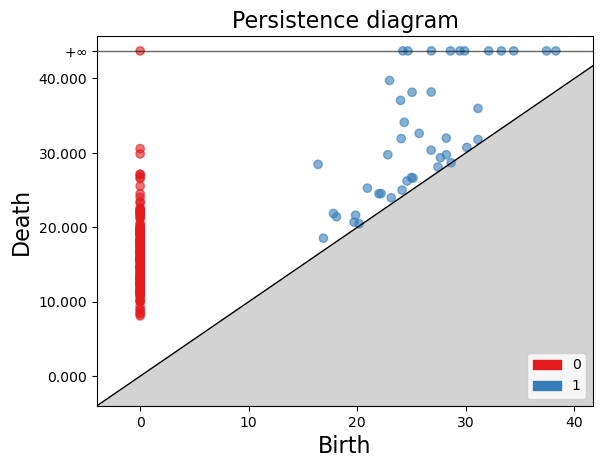

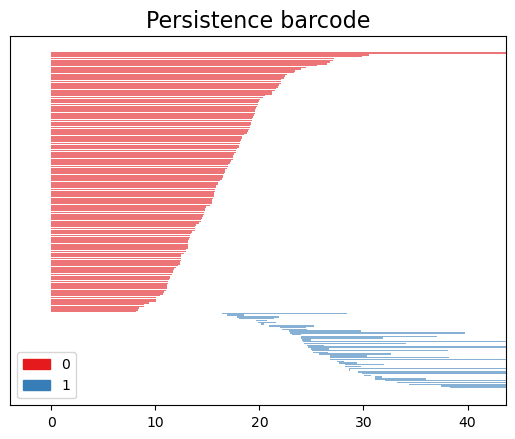

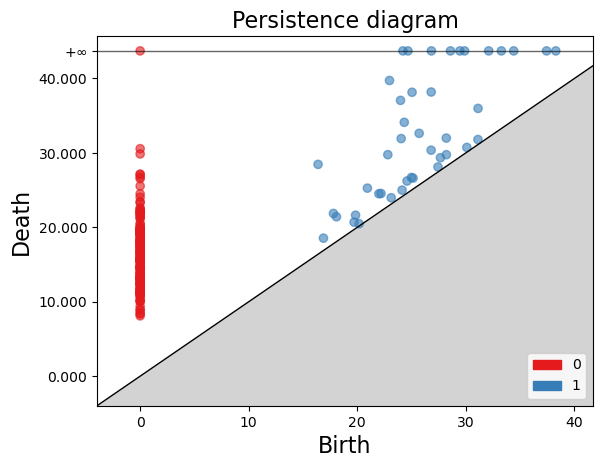

In [66]:
import gudhi as gd
import matplotlib.pyplot as plt
# Define the edge length interval (min_edge_length, max_edge_length)
min_edge_length = 0.05

## this parameter is the key determinant of time cost
max_edge_length = 40

# Create a Rips complex with a higher max_edge_length
rips_complex = gd.RipsComplex(points=point_cloud, max_edge_length=max_edge_length)

# Create a simplex tree for the Rips complex, specifying max dimension
simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)

# Convert the filtration generator to a list for processing
filtration = list(simplex_tree.get_filtration())

# Compute persistence
simplex_tree.compute_persistence()

# Print persistence intervals (birth and death) for each homology dimension
print("Persistence intervals for homology groups:")
intervals = simplex_tree.persistence()
for dim, (birth, death) in intervals:
    print(f"Dimension {dim}: Birth = {birth}, Death = {death}")

# Plot the persistence diagram
gd.plot_persistence_diagram(intervals)
plt.show()
# Plot the persistence barcode
gd.plot_persistence_barcode(intervals)
plt.show()

# Filter out short-lived features with the correct structure
filtered_intervals = [(dim, (birth, death)) for dim, (birth, death) in intervals if death - birth >= min_persistence]

# Plot the filtered persistence diagram
gd.plot_persistence_diagram(filtered_intervals)
plt.show()


## SCRATCH below here ##

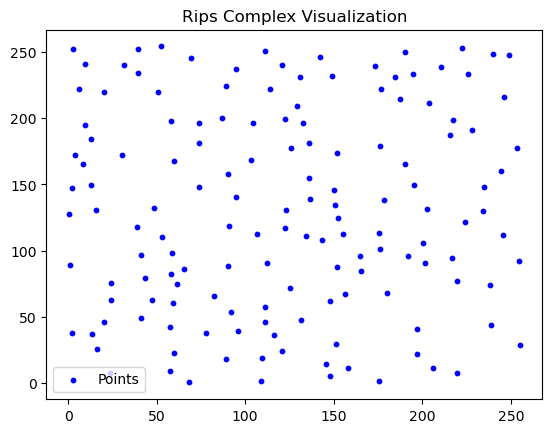

In [39]:
import numpy as np

# Plot the original point cloud
plt.scatter(point_cloud[:, 1], point_cloud[:, 0], color='blue', s=10, label='Points')

# Plot the edges (1-simplices)
for simplex, filtration_value in filtration:
    if len(simplex) == 2:  # 1-simplex (edge)
        i, j = simplex
        plt.plot([point_cloud[i][1], point_cloud[j][1]], [point_cloud[i][0], point_cloud[j][0]], 'k-', alpha=0.5)

# Optionally, plot the triangles (2-simplices)
for simplex, filtration_value in filtration:
    if len(simplex) == 3:  # 2-simplex (triangle)
        i, j, k = simplex
        plt.plot([point_cloud[i][1], point_cloud[j][1]], [point_cloud[i][0], point_cloud[j][0]], 'g-', alpha=0.2)
        plt.plot([point_cloud[j][1], point_cloud[k][1]], [point_cloud[j][0], point_cloud[k][0]], 'g-', alpha=0.2)
        plt.plot([point_cloud[k][1], point_cloud[i][1]], [point_cloud[k][0], point_cloud[i][0]], 'g-', alpha=0.2)

plt.title("Rips Complex Visualization")
plt.legend()
plt.show()


In [2]:
# visualize the mask
import open3d as o3d
import numpy as np

# Extract point cloud from the binary mask (1s for stroma, 0s for holes)
points = np.argwhere(mask_array > 0)  # Extract points representing the stroma

# Convert the points to an Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd], window_name="Stroma Mask Point Cloud")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
import numpy as np

# Invert the mask to focus on holes (holes will now be 1, stroma will be 0)
inverted_mask = np.logical_not(mask_array).astype(int)

# Extract the point cloud of the holes
point_cloud = np.argwhere(inverted_mask > 0)
point_clouda = np.argwhere(inverted_mask < 1)
print(f"Extracted point cloud of holes: {point_cloud.shape}")




Extracted point cloud of holes: (4655383, 3)


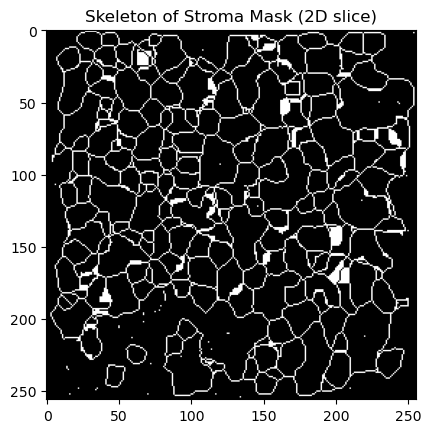

In [4]:
import numpy as np
from skimage.morphology import skeletonize_3d
import matplotlib.pyplot as plt

# Load your binary mask
# Assuming the binary mask (segmentation) is already loaded as `mask_array`

# Skeletonize the 3D binary mask
skeleton = skeletonize_3d(mask_array)

# Visualize a slice of the skeleton (2D view)
plt.imshow(skeleton[100, :, :], cmap='gray')  # Visualize the 100th Z-slice of the skeleton
plt.title("Skeleton of Stroma Mask (2D slice)")
plt.show()


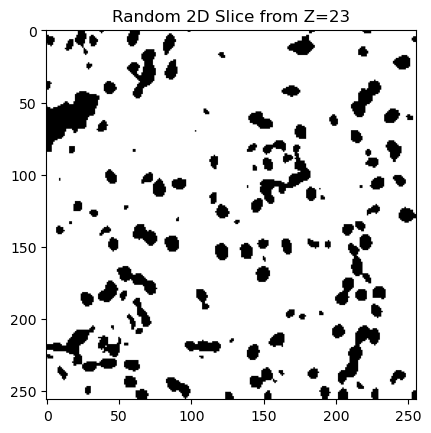

In [7]:
# compute PH on random slice for mem purposes
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser

# Assuming `mask_array` is your 3D binary segmentation mask
Z, Y, X = mask_array.shape

# Choose a random Z-slice
random_z = np.random.randint(0, Z)

# Extract the 2D slice from the binary mask
slice_2d = mask_array[random_z, :, :]

# Visualize the 2D slice
plt.imshow(slice_2d, cmap='gray')
plt.title(f"Random 2D Slice from Z={random_z}")
plt.show()


In [ ]:
# Extract point cloud from the 2D slice (points where the slice is 1)
point_cloud_2d = np.argwhere(slice_2d > 0)

print(f"Point cloud shape: {point_cloud_2d.shape}")
# Run persistent homology on the point cloud from the 2D slice
results_2d = ripser(point_cloud_2d, maxdim=1)

# Plot the persistence diagram for H₁ (holes)
plt.figure()
plt.title(f"Persistence Diagram for 2D Slice (Z={random_z})")
plt.scatter(*zip(*results_2d['dgms'][1]), label='Holes (H₁)')
plt.xlabel("Birth")
plt.ylabel("Death")
plt.legend()
plt.show()

# Optional: Print the persistence intervals for H₁ (holes)
print(f"Persistence Intervals for H₁ (holes) in slice Z={random_z}:")
print(results_2d['dgms'][1])


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

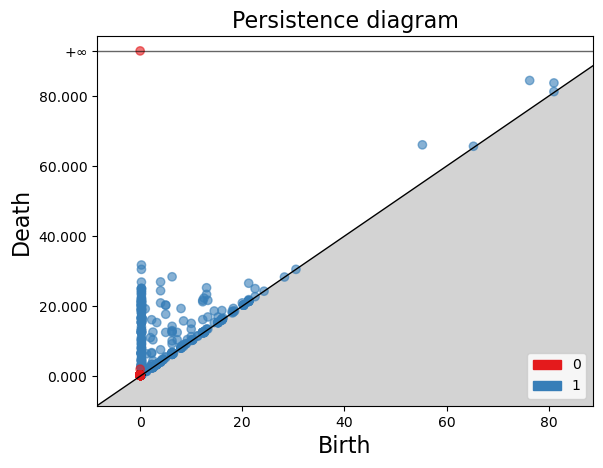

In [8]:
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt

# Use the point cloud extracted from the 2D slice
point_cloud_2d = np.argwhere(slice_2d > 0)

# Build the Alpha Complex from the point cloud
alpha_complex = gd.AlphaComplex(points=point_cloud_2d)
simplex_tree = alpha_complex.create_simplex_tree()

# Compute persistent homology on the Alpha Complex
simplex_tree.persistence()

# Plot the persistence diagram
gd.plot_persistence_diagram(simplex_tree.persistence())

